In [1]:
import plotly.express as px
from tinyshift.series import trend_significance
from utilsforecast.preprocessing import fill_gaps
from utilsforecast.data import generate_series
from tinyshift.plot import corr_heatmap
import plotly.express as px
from utils import remove_leading_zeros, is_obsolete, forecastability, plot_acf_pacf_adf, generate_lag, add_fourier_seasonality
from scipy import signal
import holidays
import pandas as pd
import numpy as np

In [2]:
df = generate_series(3, with_trend=True, static_as_categorical=False, seed=42, freq="D")

In [3]:
df.isnull().sum()

unique_id    0
ds           0
y            0
dtype: int64

In [4]:
df = fill_gaps(df, freq="D", end="per_serie", id_col="unique_id", time_col="ds")

In [5]:
df = df.groupby("unique_id")[df.columns].apply(remove_leading_zeros).reset_index(drop=True)

In [6]:
days_obsoletes=180
obsolete_series = df.groupby("unique_id")[df.columns].apply(is_obsolete, days_obsoletes)

In [7]:
obsolote_ids = obsolete_series[obsolete_series].index.tolist()

In [8]:
obsolote_ids

[]

In [9]:
df.groupby("unique_id")["y"].apply(trend_significance)

unique_id
0    (0.9894087777029937, 4.8574508252298796e-150)
1                         (0.998759437594496, 0.0)
2                        (0.9990776434701963, 0.0)
Name: y, dtype: object

In [10]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [11]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [12]:
df.groupby("unique_id")["y"].apply(forecastability)

unique_id                   
0          foreCA                                                  0.616734
           theoretical_limit                                       0.560748
           stability_index                                         0.937922
           adi_cv                                (1.0, 0.28499520299004516)
           hurst_exponent         (0.3290861603798452, 0.13218639190520123)
1          foreCA                                                  0.702415
           theoretical_limit                                        0.55557
           stability_index                                           0.9567
           adi_cv                                (1.0, 0.31390442751597913)
           hurst_exponent       (0.28893923895853546, 0.032089718874560705)
2          foreCA                                                  0.691794
           theoretical_limit                                       0.558174
           stability_index                                 

In [13]:
df["lag_1"] = df.groupby("unique_id")["y"].transform(generate_lag)
df["detrend"] = df.groupby("unique_id")["y"].transform(signal.detrend)
df["detrend_lag_7"] = df.groupby("unique_id")["detrend"].transform(generate_lag, lag=7)

# ACF/PACF

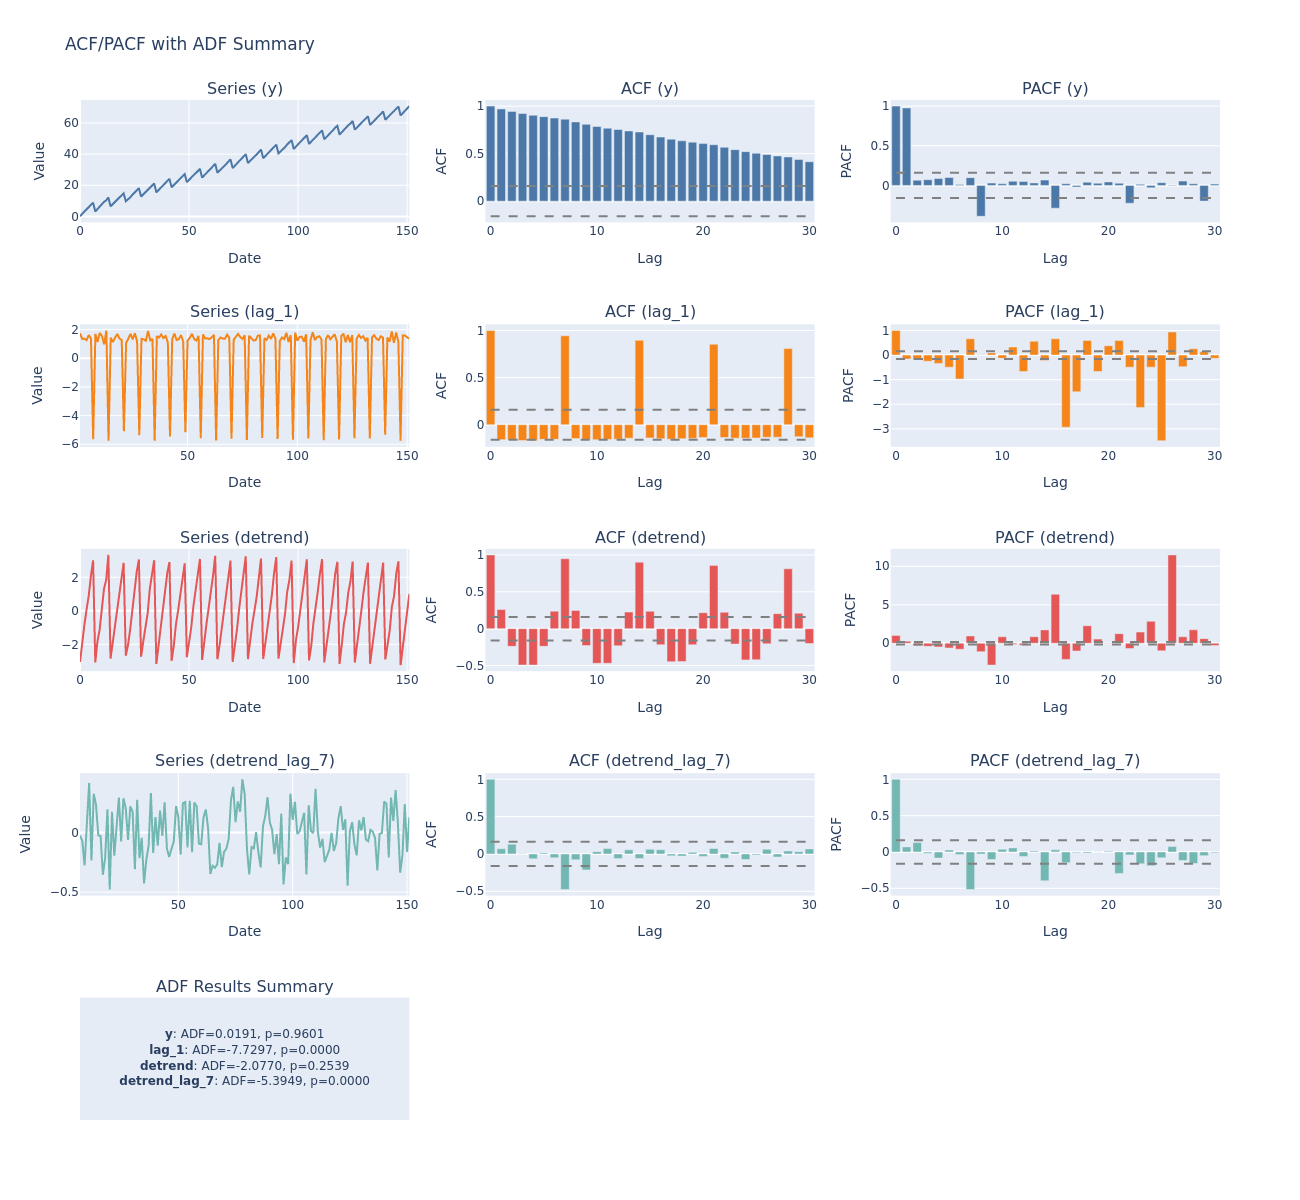

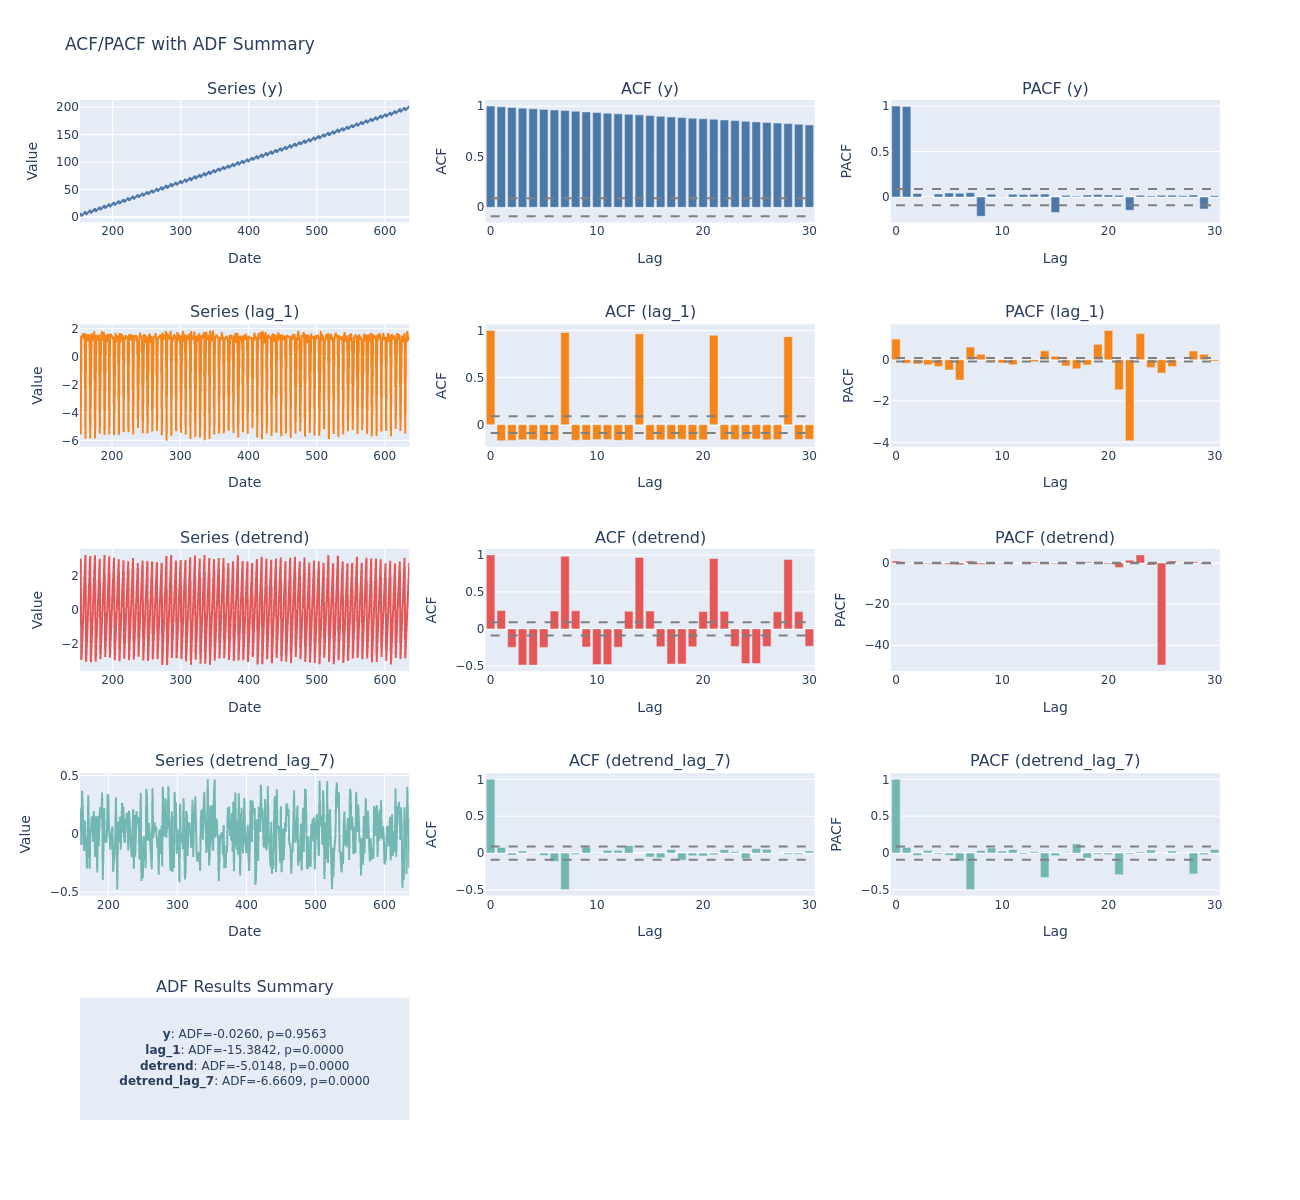

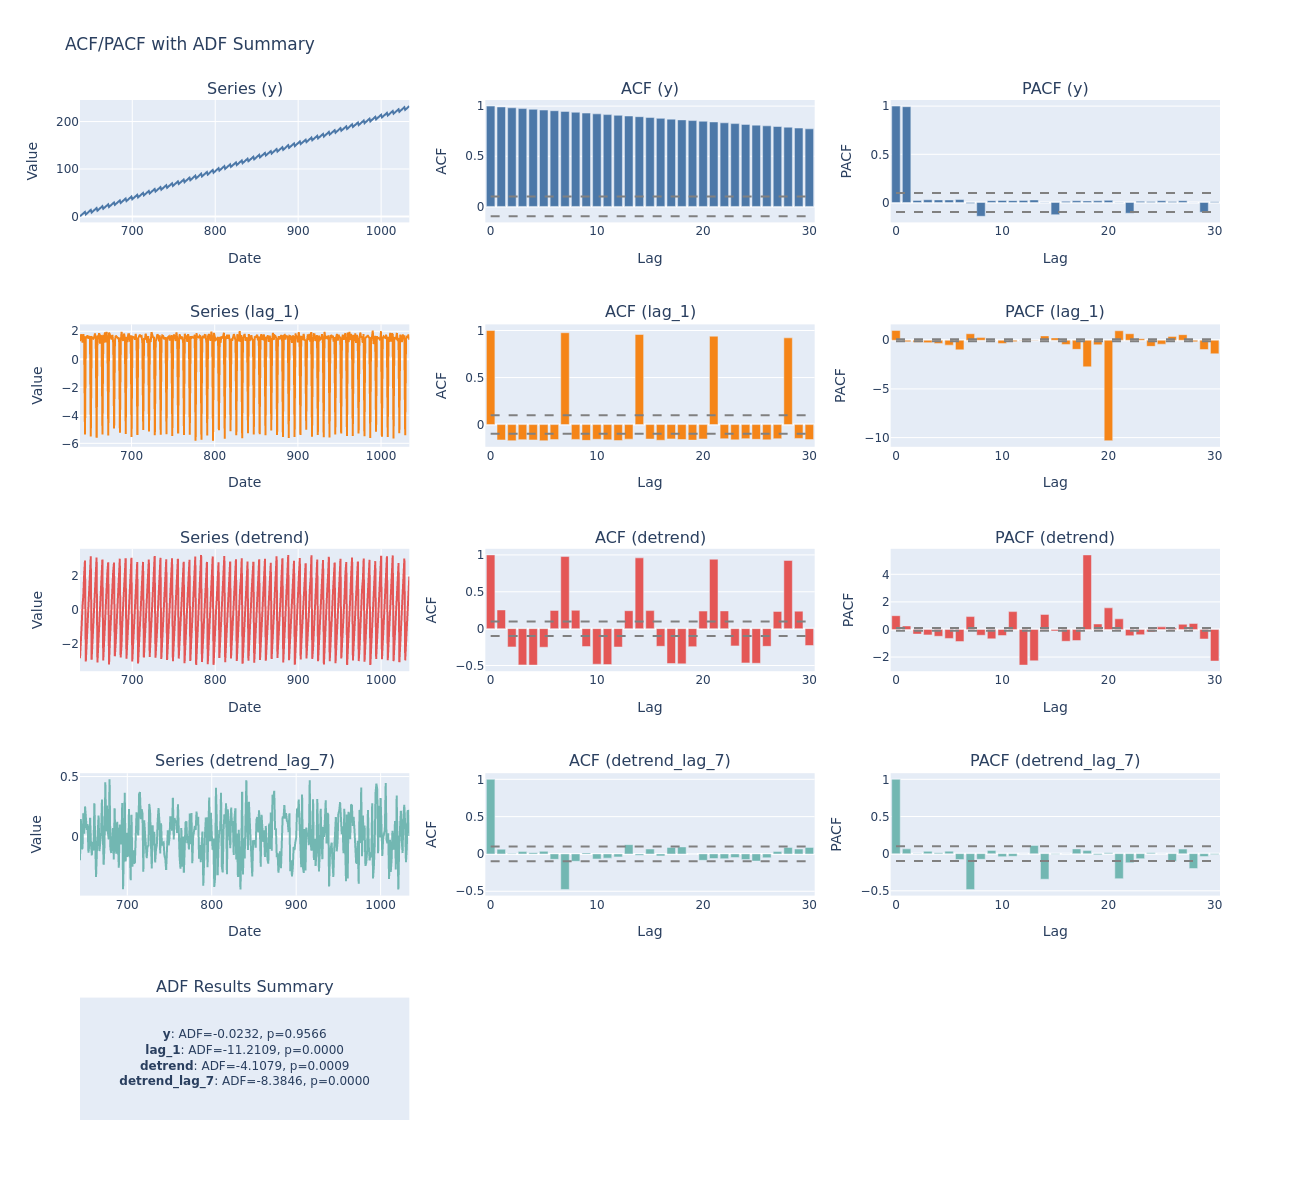

In [14]:
for id in df["unique_id"].unique():
    plot_acf_pacf_adf(df[df["unique_id"] == id], ["y", "lag_1", "detrend", "detrend_lag_7"], fig_type="png")

# STL

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plotSeasonalDecompose(
    x,
    model='additive',
    filt=None,
    period=None,
    two_sided=True,
    extrapolate_trend=0,
    title="Seasonal Decomposition"):

    result = seasonal_decompose(
            x, model=model, filt=filt, period=period,
            two_sided=two_sided, extrapolate_trend=extrapolate_trend)
    fig = make_subplots(
            rows=4, cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"])
    for idx, col in enumerate(['observed', 'trend', 'seasonal', 'resid']):
        fig.add_trace(
            go.Scatter(x=result.observed.index, y=getattr(result, col), mode='lines'),
                row=idx+1, col=1,
            )
    return fig

In [16]:
plotSeasonalDecompose(
    df[df["unique_id"] == 0]["y"],
    period=7,
    title="Seasonal Decomposition for id_0"
)

## Features
- ~~Holidays~~
- ~~Série de fourier para padrões cíclicos (seno e cosseno) - dia da semana, dia do ano~~
- ~~mês~~
- ~~fim do mês~~
- ~~Lags~~
- Rolling Windows: médias, desvio padrão e permutação da entropia

In [17]:
df = add_fourier_seasonality(df, "ds", seasonality=["weekly", "yearly"])
holidays_br = holidays.country_holidays("Brazil")
df["is_holiday"] = np.array([timestamp in holidays_br for timestamp in df["ds"]])
df["is_month_end"] = df["ds"].dt.is_month_end

In [18]:
df = df.dropna()

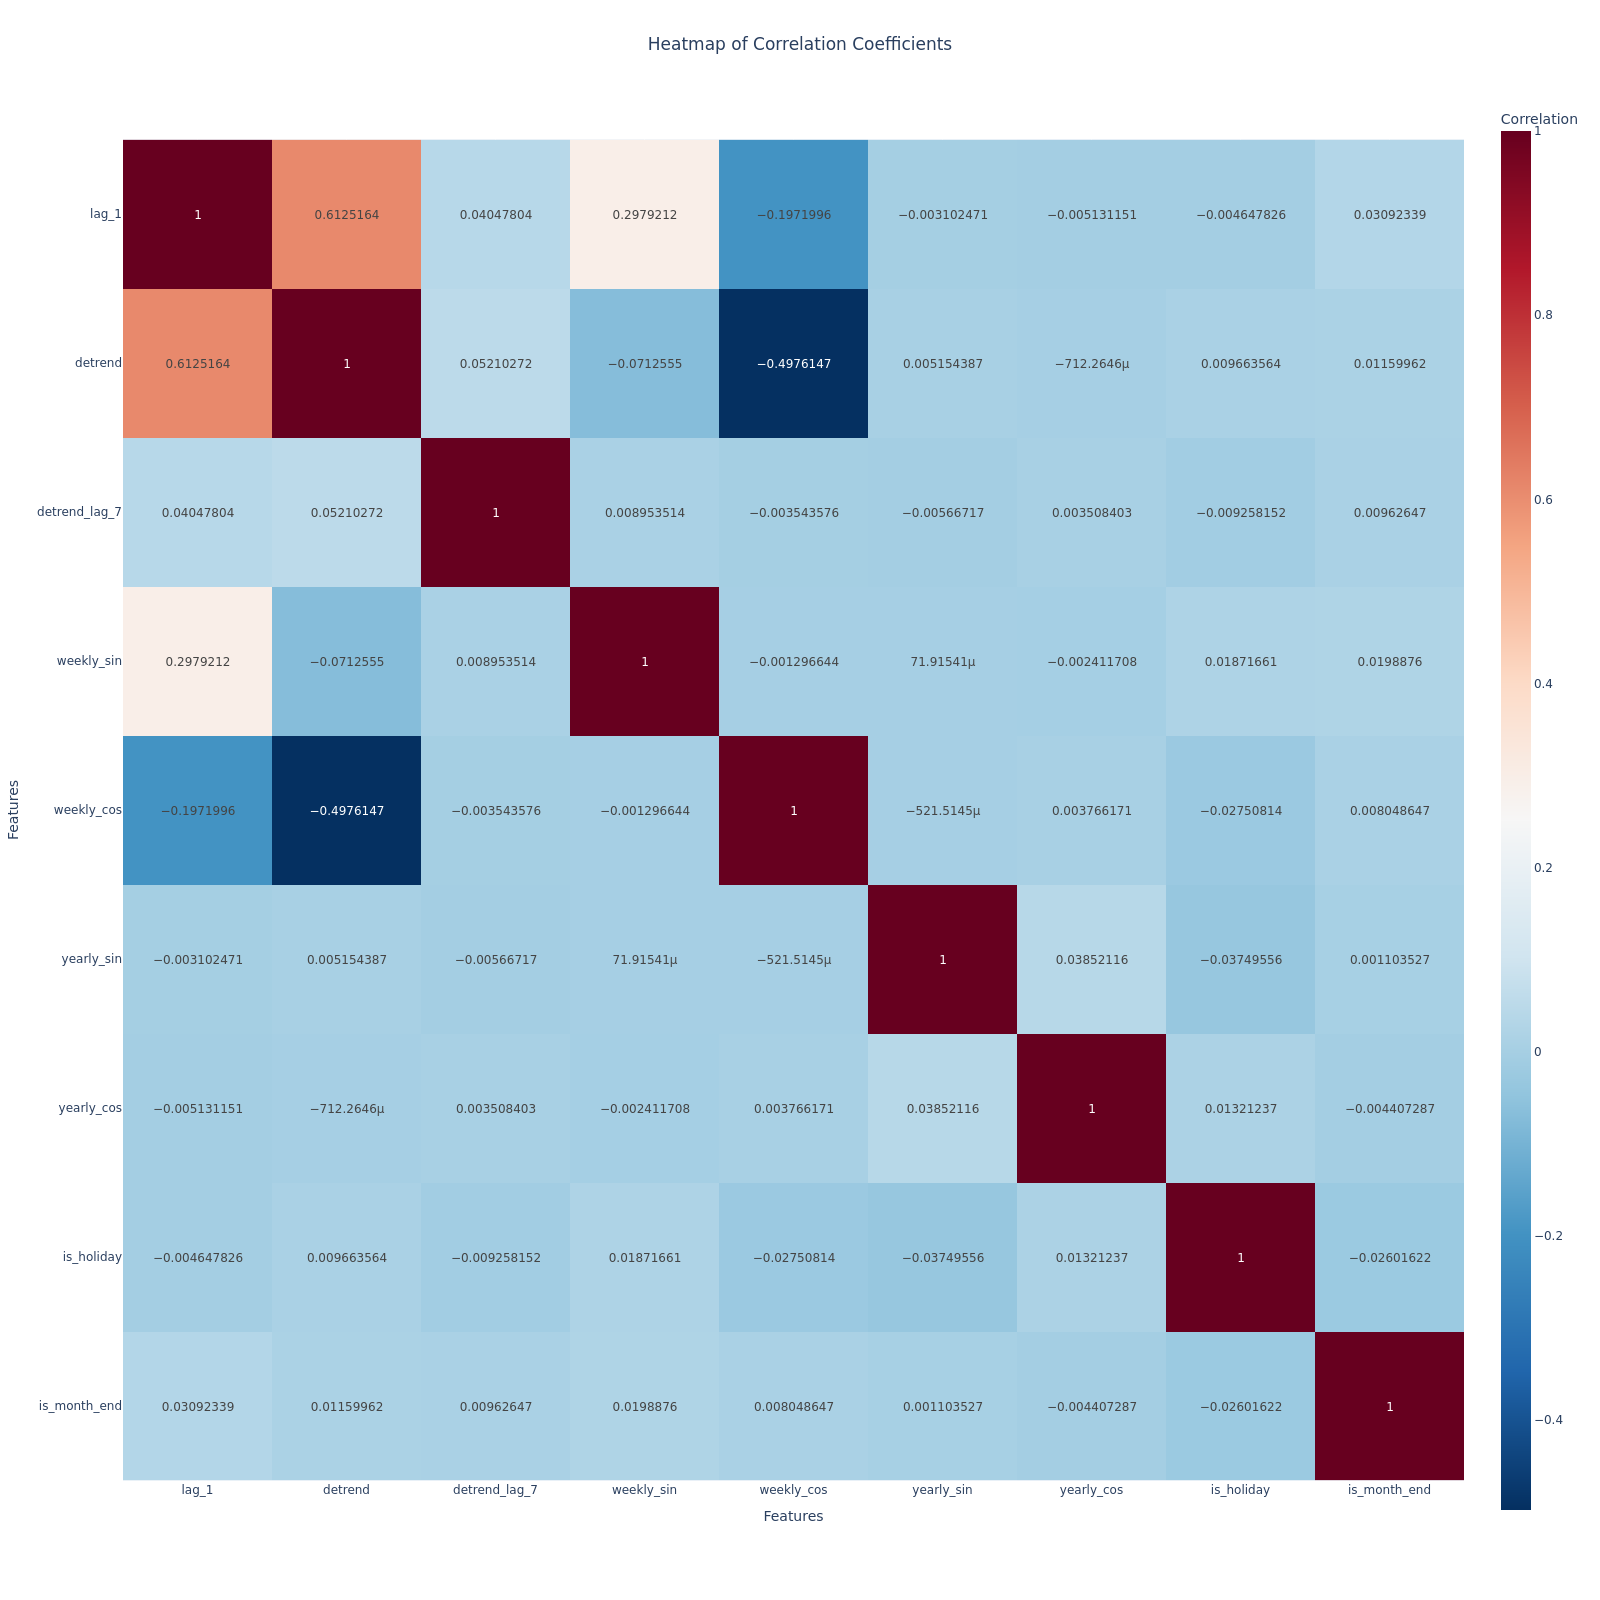

In [19]:
corr_heatmap(df[df.columns[3:]], fig_type="png")

# Modelagem (Decomposição + Modelagem Residual)

1. modelo estatístico + ML residual
2. ver como fazer Tendência aditivia, sazonalidade multiplicativa
3. ver como fazer tendência aditiva, sazonalidade aditiva